In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.2.0-SNAPSHOT-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
def loadContinuousData(df, outputDataset = False):
    tetradData = None

    node_list = javabridge.JClassWrapper("java.util.ArrayList")()
    # load dataset
    for col in df.columns:
        nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
        node_list.add(nodi)
    
    dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(df.index),df.columns.size)
    
    for col in range(0,df.columns.size):
        for row in df.index:
            value = javabridge.make_instance("java/lang/Double", "(D)V", df.iloc[row,col])
            dataBox.set(row,col,value)
    
    tetradData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)
    
    return tetradData

In [5]:
datasets = javabridge.JClassWrapper('java.util.ArrayList')()
tetrad_images_dir = os.path.join(os.getcwd(), '../../', 'data', '9var')
for d in glob.glob(tetrad_images_dir + os.sep + "*.txt"):
    print (d)
    df = pd.read_table(d, sep="\t")
    tetradData = loadContinuousData(df)
    datasets.add(tetradData)

/home/jovyan/py-causal/example/javabridge/../../data/9var/sub004.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub017.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub014.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub010.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub005.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub016.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub009.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub001.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub013.cent-table.9.dat.txt


In [6]:
penaltyDiscount = 4
maxDegree = 3
faithfulnessAssumed = True
verbose = True
# numBootstrap = 5
# ensembleMethod = 'Highest'

In [7]:
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.SemBicScoreImages')(datasets)
score.setPenaltyDiscount(penaltyDiscount)

In [8]:
fges = javabridge.JClassWrapper('edu.cmu.tetrad.search.Fges')(score)
fges.setMaxDegree(maxDegree)
fges.setFaithfulnessAssumed(faithfulnessAssumed)
fges.setVerbose(verbose)

In [9]:
tetradGraph = fges.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
LOCC;LACC;LIFG;LIPL;ROCC;RACC;RIFG;RIPL;I

Graph Edges:
1. I --- LOCC
2. LACC --> RACC
3. LIFG --- LACC
4. LIFG --> RIFG
5. LIPL --- LIFG
6. LIPL --- LOCC
7. RIPL --- LIPL
8. RIPL --> RACC
9. RIPL --> RIFG
10. ROCC --- LOCC

Graph Attributes:
BIC: 0.000000


In [10]:
tetradGraph.toString()

'Graph Nodes:\nLOCC;LACC;LIFG;LIPL;ROCC;RACC;RIFG;RIPL;I\n\nGraph Edges:\n1. I --- LOCC\n2. LACC --> RACC\n3. LIFG --- LACC\n4. LIFG --> RIFG\n5. LIPL --- LIFG\n6. LIPL --- LOCC\n7. RIPL --- LIPL\n8. RIPL --> RACC\n9. RIPL --> RIFG\n10. ROCC --- LOCC\n\nGraph Attributes:\nBIC: 0.000000\n\n'

In [11]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [LOCC, LACC, LIFG, LIPL, ROCC, RACC, RIFG, RIPL, I]

In [12]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [LIPL --- LIFG, LIFG --- LACC, RIPL --- LIPL, RIPL --> RIFG, ROCC --- LOCC, LIPL --- LOCC, LIFG --> RIFG, LACC --> RACC, RIPL --> RACC, I --- LOCC]

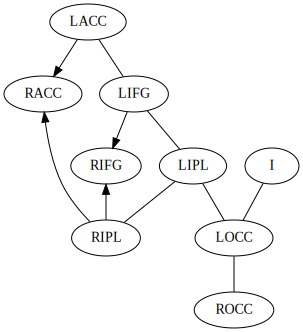

In [13]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [14]:
javabridge.detach()
javabridge.kill_vm()